# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL25Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/homework-1.ipynb) of this homework from your local copy.

For part A, fill in the code and answers within the notebook and save your changes.

For part B, create and archive the necessary Python/shell scripts together.

Finally, upload the notebook and the archive to the assignment in ILIAS.

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [1]:
import pandas as pd
import seaborn as sns
from lab.tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of up to around 0.1%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (for the different decentralized data learning parameters) weight and gradient FedSGD are equivalent.

#### Answer

In [2]:
"""
class FedSGDServer(FedAvgServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)
        self.name = "FedSGD"
        # Set the number of local epochs to 1 and batch size to the given batch size
        self.nr_local_epochs = 1
        self.batch_size = b
        self.clients = [
            WeightClient(subset, lr, self.batch_size, self.nr_local_epochs)
            for subset in client_subsets]
"""

'\nclass FedSGDServer(FedAvgServer):\n    def __init__(\n            self, lr: float, batch_size: int, client_subsets: list[Subset],\n            client_fraction: float, nr_local_epochs: int, seed: int) -> None:\n        super().__init__(lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed)\n        self.name = "FedSGD"\n        # Set the number of local epochs to 1 and batch size to the given batch size\n        self.nr_local_epochs = 1\n        self.batch_size = b\n        self.clients = [\n            WeightClient(subset, lr, self.batch_size, self.nr_local_epochs)\n            for subset in client_subsets]\n'

In [2]:
class FedSGDServer(DecentralizedServer):
    def __init__(
            self, lr: float, batch_size: int, client_subsets: list[Subset],
            client_fraction: float, nr_local_epochs: int, seed: int) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        # Set the name of the server
        self.name = "FedSGD"
        # Set the number of local epochs
        self.nr_local_epochs = nr_local_epochs
        # Initialize the clients with their respective subsets, learning rate, batch size, and number of local epochs
        self.clients = [
            WeightClient(subset, lr, b, 1)
            for subset in client_subsets]

    def run(self, nr_rounds: int) -> RunResult:
        elapsed_time = 0.
        run_result = RunResult(
            self.name, self.nr_clients, self.client_fraction, self.batch_size,
            self.nr_local_epochs, self.lr, self.seed)

        # Iterate over the number of rounds
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False)
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients)
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.

            # Iterate over the chosen clients
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append([
                    self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                     for tens in client_weights])
                update_time = max(update_time, perf_counter() - update_start_time)

            # Update the elapsed time
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_chosen_weights: list[torch.Tensor] = [
                torch.stack(x, dim=0).sum(dim=0) for x in zip(*chosen_adjusted_weights)]

            # Update the server's model with the averaged weights
            with torch.no_grad():
                zip_weight_parameter = zip(averaged_chosen_weights, self.model.parameters())
                for client_weight, server_parameter in zip_weight_parameter:
                    server_parameter[:] = client_weight.to(device=device)

            # Update the elapsed time
            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(2 * (nr_round + 1) * self.nr_clients_per_round)
            run_result.test_accuracy.append(self.test())

        # Return the run result
        return run_result

In [4]:
lr = 0.01
c = 0.5
n = 100
nr_rounds = 5
client_subsets = split(n, True, seed)

fedavg_server = FedAvgServer(lr, b, client_subsets, c, e,seed)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.5,100,1,0.01,10,100,31.26
1,2,FedAvg,100,0.5,100,1,0.01,10,200,45.76
2,3,FedAvg,100,0.5,100,1,0.01,10,300,54.13
3,4,FedAvg,100,0.5,100,1,0.01,10,400,63.45
4,5,FedAvg,100,0.5,100,1,0.01,10,500,67.25


In [5]:
fedsgdw_server = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgdw = fedsgdw_server.run(5)
fedsgdw_df = result_fedsgdw.as_df()
fedsgdw_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGD,100,0.5,100,1,0.01,10,100,31.26
1,2,FedSGD,100,0.5,100,1,0.01,10,200,45.76
2,3,FedSGD,100,0.5,100,1,0.01,10,300,54.13
3,4,FedSGD,100,0.5,100,1,0.01,10,400,63.45
4,5,FedSGD,100,0.5,100,1,0.01,10,500,67.25


In [6]:
lr = 0.1
c = 0.2
n = 50
client_subsets = split(n, False, seed)

fedavg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg = fedavg_server.run(5)
fedavg_df = result_fedavg.as_df()
fedavg_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,50,0.2,100,1,0.1,10,20,14.26
1,2,FedAvg,50,0.2,100,1,0.1,10,40,12.51
2,3,FedAvg,50,0.2,100,1,0.1,10,60,33.32
3,4,FedAvg,50,0.2,100,1,0.1,10,80,56.19
4,5,FedAvg,50,0.2,100,1,0.1,10,100,56.06


In [7]:
fedsgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(5)
fedsgd_df = result_fedsgd.as_df()
fedsgd_df

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedSGD,50,0.2,100,1,0.1,10,20,14.26
1,2,FedSGD,50,0.2,100,1,0.1,10,40,12.51
2,3,FedSGD,50,0.2,100,1,0.1,10,60,33.32
3,4,FedSGD,50,0.2,100,1,0.1,10,80,56.19
4,5,FedSGD,50,0.2,100,1,0.1,10,100,56.06


### Exercise A2: Client number & fraction (4 points)

#### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |               |               |
| FedAvg    | 10  | 0.1 |               |               |
| FedSGD    | 50  | 0.1 |               |               |
| FedAvg    | 50  | 0.1 |               |               |
| FedSGD    | 100 | 0.1 |               |               |
| FedAvg    | 100 | 0.1 |               |               |

Is the relationship between the metrics/algorithms and client numbers monotonous? Briefly explain your reasoning.

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |               |               |
| FedAvg    | 100 | 0.01 |               |               |
| FedSGD    | 100 | 0.1  |               |               |
| FedAvg    | 100 | 0.1  |               |               |
| FedSGD    | 100 | 0.2  |               |               |
| FedAvg    | 100 | 0.2  |               |               |

How do the observed relationships compare to before? Again, succintly argue your answer.

#### Answer

In [8]:
n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

# N = 10, C = 0.1
n = 10
c = 0.1
client_subsets = split(n, True, 10)
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)


# N = 50, C = 0.1
n = 50
client_subsets = split(n, True, 10)

fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)


# N = 100, C = 0.1
n = 100
client_subsets = split(n, True, 10)

fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)

FedAvg Results:
   Round Algorithm   N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  10  0.1  100  1  0.01    10              2          74.25
1      2    FedAvg  10  0.1  100  1  0.01    10              4          87.47
2      3    FedAvg  10  0.1  100  1  0.01    10              6          88.71
3      4    FedAvg  10  0.1  100  1  0.01    10              8          90.13
4      5    FedAvg  10  0.1  100  1  0.01    10             10          90.91
5      6    FedAvg  10  0.1  100  1  0.01    10             12          91.17
6      7    FedAvg  10  0.1  100  1  0.01    10             14          91.75
7      8    FedAvg  10  0.1  100  1  0.01    10             16          92.69
8      9    FedAvg  10  0.1  100  1  0.01    10             18          91.91
9     10    FedAvg  10  0.1  100  1  0.01    10             20          92.68

FedSGD Results:
   Round Algorithm   N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD  10  0.1  10

FedAvg Results:
   Round Algorithm   N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  50  0.1  100  1  0.01    10             10          48.27
1      2    FedAvg  50  0.1  100  1  0.01    10             20          66.79
2      3    FedAvg  50  0.1  100  1  0.01    10             30          67.39
3      4    FedAvg  50  0.1  100  1  0.01    10             40          78.39
4      5    FedAvg  50  0.1  100  1  0.01    10             50          81.47
5      6    FedAvg  50  0.1  100  1  0.01    10             60          83.40
6      7    FedAvg  50  0.1  100  1  0.01    10             70          85.72
7      8    FedAvg  50  0.1  100  1  0.01    10             80          86.27
8      9    FedAvg  50  0.1  100  1  0.01    10             90          87.46
9     10    FedAvg  50  0.1  100  1  0.01    10            100          87.78

FedSGD Results:
   Round Algorithm   N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD  50  0.1  10

FedAvg Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.1  100  1  0.01    10             20          31.35
1      2    FedAvg  100  0.1  100  1  0.01    10             40          46.75
2      3    FedAvg  100  0.1  100  1  0.01    10             60          57.45
3      4    FedAvg  100  0.1  100  1  0.01    10             80          64.41
4      5    FedAvg  100  0.1  100  1  0.01    10            100          70.70
5      6    FedAvg  100  0.1  100  1  0.01    10            120          74.03
6      7    FedAvg  100  0.1  100  1  0.01    10            140          76.37
7      8    FedAvg  100  0.1  100  1  0.01    10            160          77.58
8      9    FedAvg  100  0.1  100  1  0.01    10            180          78.49
9     10    FedAvg  100  0.1  100  1  0.01    10            200          81.91

FedSGD Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD 

TODO

In [9]:
# N = 100, C = 0.01
n = 100
c = 0.01
client_subsets = split(n, True, 10)
fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)


# N = 100, C = 0.1
c = 0.1
client_subsets = split(n, True, 10)

fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)


# N = 100, C = 0.2
c = 0.2
client_subsets = split(n, True, 10)

fed_avg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
fed_sgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)

result_fedavg = fed_avg_server.run(nr_rounds)
result_fedsgd = fed_sgd_server.run(nr_rounds)
fedavg_df = result_fedavg.as_df()
fedsgd_df = result_fedsgd.as_df()
print("FedAvg Results:")
print(fedavg_df)
print("\nFedSGD Results:")
print(fedsgd_df)

FedAvg Results:
   Round Algorithm    N     C    B  E     η  Seed  Message count  \
0      1    FedAvg  100  0.01  100  1  0.01    10              2   
1      2    FedAvg  100  0.01  100  1  0.01    10              4   
2      3    FedAvg  100  0.01  100  1  0.01    10              6   
3      4    FedAvg  100  0.01  100  1  0.01    10              8   
4      5    FedAvg  100  0.01  100  1  0.01    10             10   
5      6    FedAvg  100  0.01  100  1  0.01    10             12   
6      7    FedAvg  100  0.01  100  1  0.01    10             14   
7      8    FedAvg  100  0.01  100  1  0.01    10             16   
8      9    FedAvg  100  0.01  100  1  0.01    10             18   
9     10    FedAvg  100  0.01  100  1  0.01    10             20   

   Test accuracy  
0          31.09  
1          39.09  
2          41.92  
3          53.99  
4          66.35  
5          71.14  
6          63.69  
7          73.35  
8          75.08  
9          76.54  

FedSGD Results:
   Round 

FedAvg Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.1  100  1  0.01    10             20          31.35
1      2    FedAvg  100  0.1  100  1  0.01    10             40          46.75
2      3    FedAvg  100  0.1  100  1  0.01    10             60          57.45
3      4    FedAvg  100  0.1  100  1  0.01    10             80          64.41
4      5    FedAvg  100  0.1  100  1  0.01    10            100          70.70
5      6    FedAvg  100  0.1  100  1  0.01    10            120          74.03
6      7    FedAvg  100  0.1  100  1  0.01    10            140          76.37
7      8    FedAvg  100  0.1  100  1  0.01    10            160          77.58
8      9    FedAvg  100  0.1  100  1  0.01    10            180          78.49
9     10    FedAvg  100  0.1  100  1  0.01    10            200          81.91

FedSGD Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD 

FedAvg Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedAvg  100  0.2  100  1  0.01    10             40          31.01
1      2    FedAvg  100  0.2  100  1  0.01    10             80          44.87
2      3    FedAvg  100  0.2  100  1  0.01    10            120          55.62
3      4    FedAvg  100  0.2  100  1  0.01    10            160          61.45
4      5    FedAvg  100  0.2  100  1  0.01    10            200          65.57
5      6    FedAvg  100  0.2  100  1  0.01    10            240          71.31
6      7    FedAvg  100  0.2  100  1  0.01    10            280          73.59
7      8    FedAvg  100  0.2  100  1  0.01    10            320          74.59
8      9    FedAvg  100  0.2  100  1  0.01    10            360          80.41
9     10    FedAvg  100  0.2  100  1  0.01    10            400          81.88

FedSGD Results:
   Round Algorithm    N    C    B  E     η  Seed  Message count  Test accuracy
0      1    FedSGD 

TODO

### Exercise A3: Local epoch count & (non-)IID data (5 points)

#### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from the point above, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the ones from before? Why do the changes in parameters have the observed effect?

#### Answer

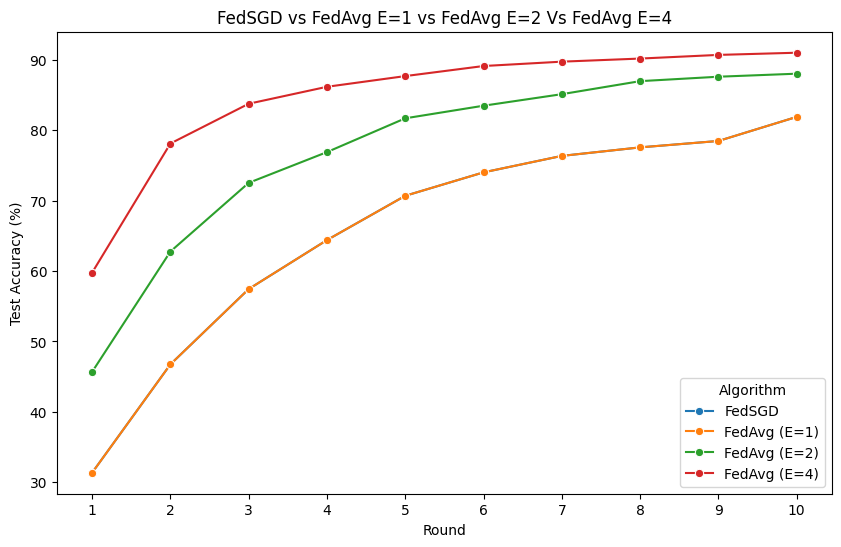

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10
client_subsets = split(n, iid, seed)

fedsgd_server = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgd = fedsgd_server.run(nr_rounds)
fedsgd_df = result_fedsgd.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavge1_df = result_fedavg1.as_df()

fedavg_server2 = FedAvgServer(lr, b, client_subsets, c, 2, seed)
result_fedavg2 = fedavg_server2.run(nr_rounds)
fedavge2_df = result_fedavg2.as_df()

fedavg_server4 = FedAvgServer(lr, b, client_subsets, c, 4, seed)
result_fedavg4 = fedavg_server4.run(nr_rounds)
fedavge4_df = result_fedavg4.as_df()

fedsgd_df['Algorithm'] = 'FedSGD'
fedavge1_df['Algorithm'] = 'FedAvg (E=1)'
fedavge2_df['Algorithm'] = 'FedAvg (E=2)'
fedavge4_df['Algorithm'] = 'FedAvg (E=4)'
df = pd.concat([fedsgd_df, fedavge1_df, fedavge2_df, fedavge4_df], ignore_index=True)
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df, x="Round", y="Test accuracy", hue="Algorithm", marker='o')
ax.set_xticks(df["Round"].unique())
ax.set_title('FedSGD vs FedAvg E=1 vs FedAvg E=2 Vs FedAvg E=4')
ax.set_xlabel('Round')
ax.set_ylabel('Test Accuracy (%)')
plt.legend(title='Algorithm')
plt.show()

TODO

In [6]:
n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
iid = True
seed = 10
client_subsets = split(n, iid, seed)
nr_rounds = 15
fedsgd_server0 = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgd0 = fedsgd_server0.run(nr_rounds)
fedsgd0_df = result_fedsgd0.as_df()

fedavg_server = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg = fedavg_server.run(nr_rounds)
fedavg0_df = result_fedavg.as_df()


In [7]:

iid = False
client_subsets = split(n, iid, seed)
fedsgd_server1 = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgd1 = fedsgd_server1.run(nr_rounds)
fedsgd1_df = result_fedsgd1.as_df()

fedavg_server1 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg1 = fedavg_server1.run(nr_rounds)
fedavg1_df = result_fedavg1.as_df()




TODO

In [8]:
lr = 0.001
c = 0.5
client_subsets = split(n, iid, seed)

fedsgd_server3 = FedSGDServer(lr, b, client_subsets, c, e, seed)
result_fedsgd3 = fedsgd_server3.run(nr_rounds)
fedsgd3_df = result_fedsgd3.as_df()

fedavg_server3 = FedAvgServer(lr, b, client_subsets, c, e, seed)
result_fedavg3 = fedavg_server3.run(nr_rounds)
fedavg3_df = result_fedavg3.as_df()

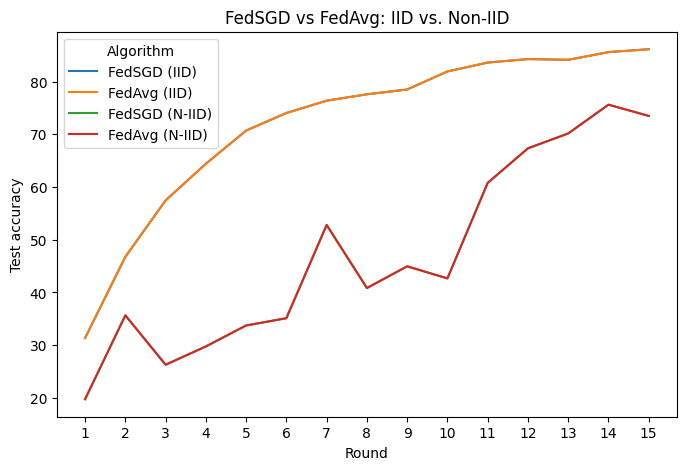

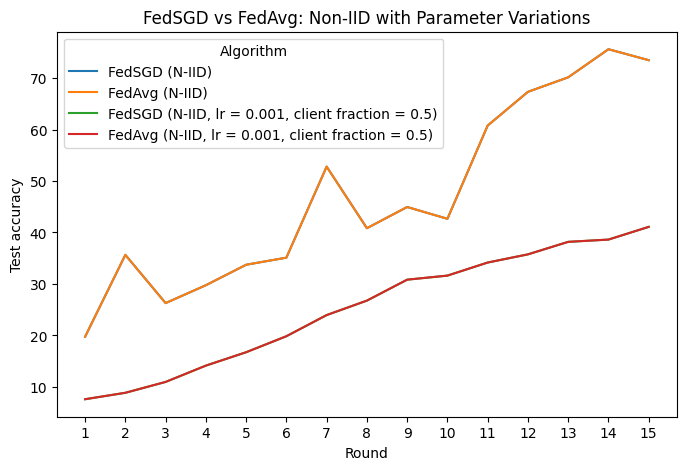

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fedsgd0_df['Algorithm'] = 'FedSGD (IID)'
fedavg0_df['Algorithm'] = 'FedAvg (IID)'
fedsgd1_df['Algorithm'] = 'FedSGD (N-IID)'
fedavg1_df['Algorithm'] = 'FedAvg (N-IID)'
df = pd.concat([fedsgd0_df, fedavg0_df, fedsgd1_df, fedavg1_df], ignore_index=True)
plt.figure(figsize=(8, 5))
sns.lineplot(df, x="Round", y="Test accuracy", hue="Algorithm")
plt.title("FedSGD vs FedAvg: IID vs. Non-IID")
plt.xticks(df["Round"].unique())
plt.show()

fedsgd3_df['Algorithm'] = 'FedSGD (N-IID, lr = 0.001, client fraction = 0.5)'
fedavg3_df['Algorithm'] = 'FedAvg (N-IID, lr = 0.001, client fraction = 0.5)'
fedsgd1_df['Algorithm'] = 'FedSGD (N-IID)'
fedavg1_df['Algorithm'] = 'FedAvg (N-IID)'
df_noniid = pd.concat([fedsgd1_df, fedavg1_df, fedsgd3_df, fedavg3_df], ignore_index=True)
plt.figure(figsize=(8, 5))
sns.lineplot(df_noniid, x="Round", y="Test accuracy", hue="Algorithm")
plt.title("FedSGD vs FedAvg: Non-IID with Parameter Variations")
plt.xticks(df["Round"].unique())
plt.show()

TODO

## Part B (12 points)

### Exercise B1: Microbatch Pipeline Model Parallelism (7 points)

Implement pipeline parallelism with microbatches, as discussed during the lab.

As with the other data/model parallelism examples, you will need a Python script for the nodes and a shell script to orchestrate execution.

Be aware of the possibility of deadlocks: due to how `gloo` operates, it is possible to deadlock by having device 1 send $B_2$ to device 2 in the forward pass, and simultaneously, device 2 send $B_1$ in the backward pass.
Since both sends will await corresponding receives, the training will stop indefinitely.

Use `isend` & `irecv`, the asynchronous (non-blocking) versions of `send` & `recv` in `torch.distributed`.
Each call of the two function returns a `Work` object, on which calling `wait()` blocks, if needed, until the message exchange finishes.
Add comments or text explaining how you expect your implementation to work and test that it runs for the same number of steps and model architecture as in class.

Note that `torch.distributed`'s implementation of `gloo` does not currently support properly asynchronous communication even when using the corresponding primitives.
Thus, you will not see the same improvements in speed as with a backend like `nccl`.

You may also use the fact that `torch` gradients naturally accumulate if not zeroed out.
Also, scaling the loss by a constant is equivalent to scaling the resulting gradients by the same constant.

You can rely on receiving messages in the same order they get sent between any device pair.
The `(i)send/recv` functions all support a `tag` attribute to match messages explicitly.
Although using it is good practice, it is not required.

You can refer to the [documentation](https://pytorch.org/docs/stable/distributed.html) and, if helpful, a related [tutorial](https://brsoff.github.io/tutorials/intermediate/dist_tuto.html) on the PyTorch website.

### Exercise B2: Joint Data & Model Parallelism (5 points)

Implement a training setup that uses data and model parallelism together.

Create 2 pipelines of 3 stages running sequentially, where each stage works with 3 sequential micro-batches.

Once again, add comments or text explaining your implementation and test it on the setting that mimics those from the class.

You can use groups from `torch.distributed` to handle reduce operations between a subset of all workers.